<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/autocorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autocorrelation

*Author: Alexander Del Toro Barba*

**Import Libraries**

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from scipy import stats

# Create Data

**Random Walk Process**

In [0]:
import numpy as np
def geometric_brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20):        
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion ###
    return S

dates = pd.date_range('2012-01-01', '2019-02-22')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 100
randomwalk = pd.Series(
    geometric_brownian_motion(T, N, sigma=0.1, S0=start_price), index=dates)

**White Noise Process**

In [0]:
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot

# seed random number generator
seed(1)

# create white noise series
whitenoise = [gauss(0.0, 1.0) for i in range(3000)]
whitenoise = Series(whitenoise)

# Visualize Data

## Random Walk Process

Text(0, 0.5, 'Value')

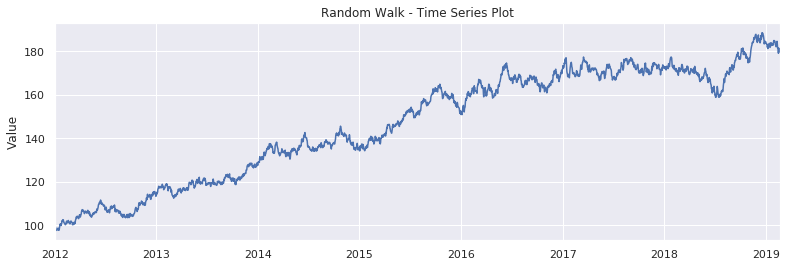

In [4]:
df = randomwalk
sns.set(rc={'figure.figsize':(13, 4)})
df.plot(linewidth=1.5,title='Random Walk - Time Series Plot')
plt.ylabel('Value')

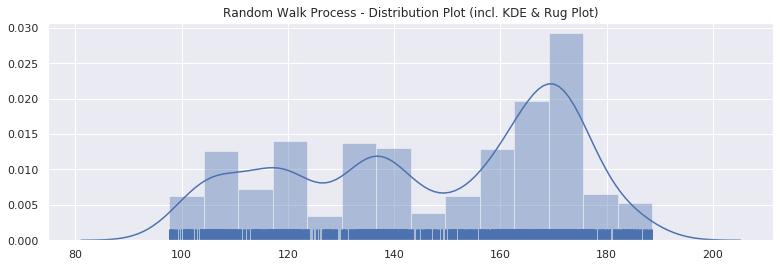

In [5]:
df = randomwalk
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('Random Walk Process - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

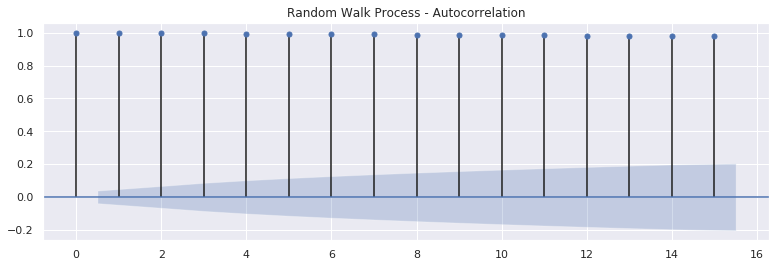

In [6]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(randomwalk.squeeze(), lags=15)
plt.title('Random Walk Process - Autocorrelation')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


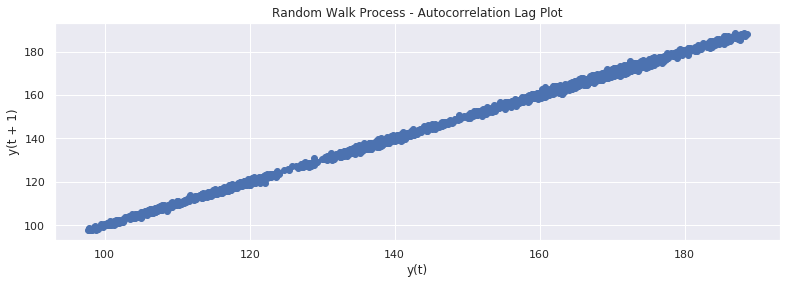

In [9]:
from pandas.plotting import lag_plot
lag_plot(randomwalk)
plt.title('Random Walk Process - Autocorrelation Lag Plot')
plt.show()

## White Noise Process

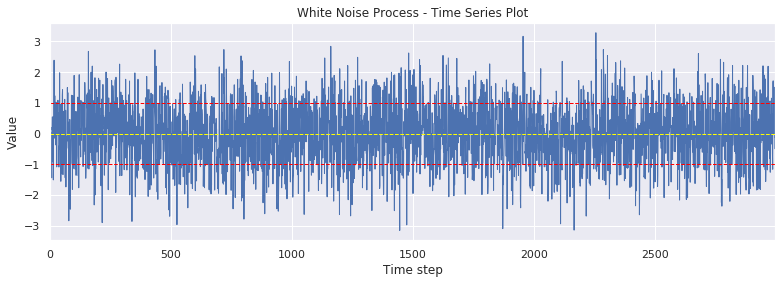

In [10]:
df = whitenoise
sns.set(rc={'figure.figsize':(13, 4)})
df.plot(linewidth=1.0,title='White Noise Process - Time Series Plot')
plt.ylabel('Value')
plt.xlabel('Time step')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.0);
plt.axhline(y=-1, color='red', linestyle='--', linewidth=1.0);
plt.axhline(y=0, color='yellow', linestyle='--', linewidth=1.0);

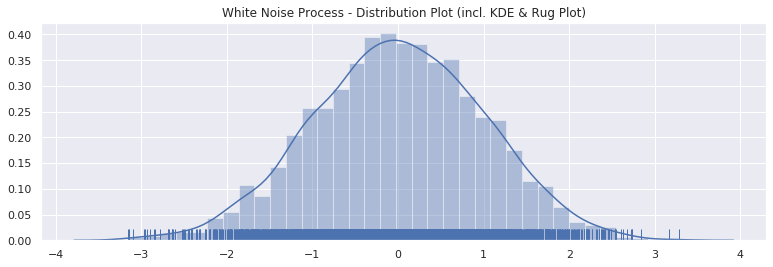

In [11]:
df = whitenoise
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('White Noise Process - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

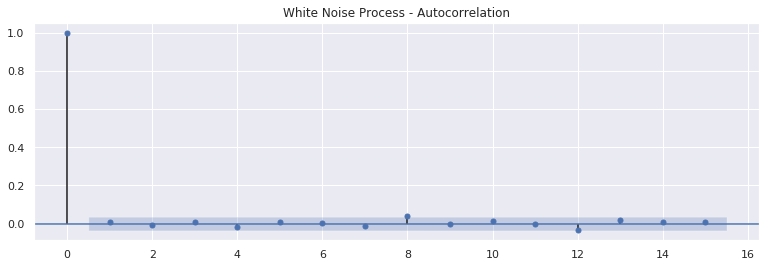

In [12]:
sns.set(rc={'figure.figsize':(13, 4)})
sm.graphics.tsa.plot_acf(whitenoise.squeeze(), lags=15)
plt.title('White Noise Process - Autocorrelation')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


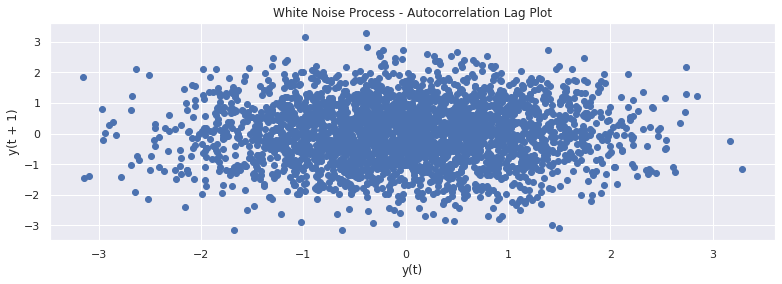

In [13]:
from pandas.plotting import lag_plot
lag_plot(whitenoise)
plt.title('White Noise Process - Autocorrelation Lag Plot')
plt.show()

# Select Data Source

In [0]:
# series = whitenoise
series = randomwalk

# Transformations

## Percentage Differenced

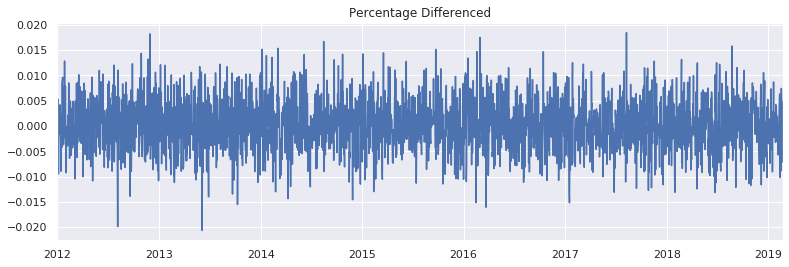

In [15]:
# Percentage Differenced
df = series / series.shift(1) -1
df.plot(title='Percentage Differenced')

## Differenced

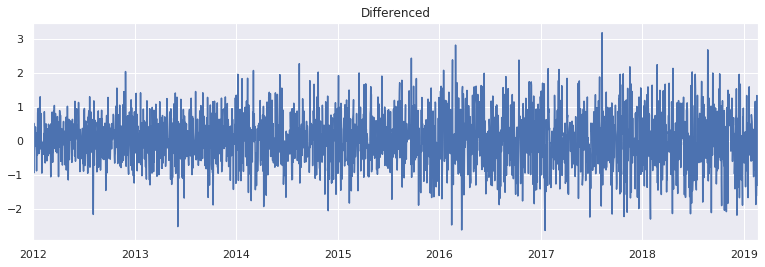

In [16]:
# Differenced
differenced = series - series.shift(1)
differenced.plot(title='Differenced')

## Square Root

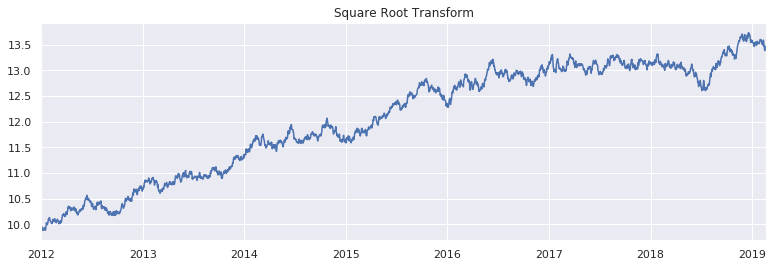

In [17]:
# Square Root Transform
sr = np.sqrt(series)
sr.plot(title='Square Root Transform')

## Log Return

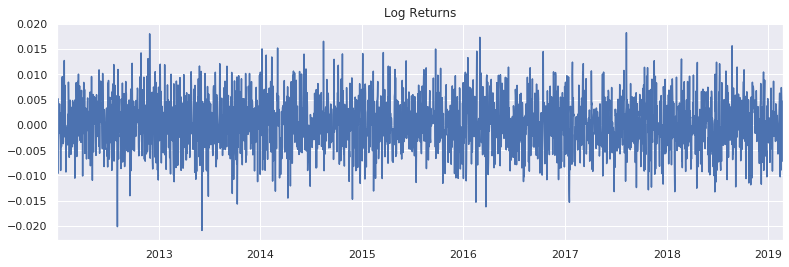

In [18]:
# Log Return
lr = np.log(series/series.shift(1)).dropna()
lr.plot(title='Log Returns')

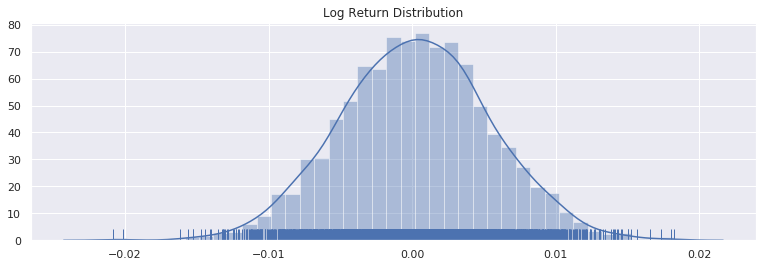

In [19]:
df = lr
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('Log Return Distribution')
plt.show()

## First Derivative

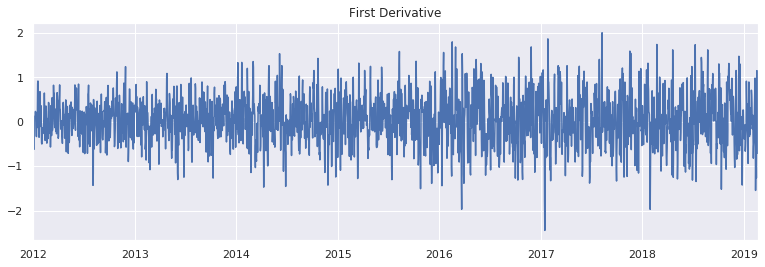

In [20]:
# First Derivative
fd = pd.Series(np.gradient(series), series.index, name='slope')
fd.plot(title='First Derivative')

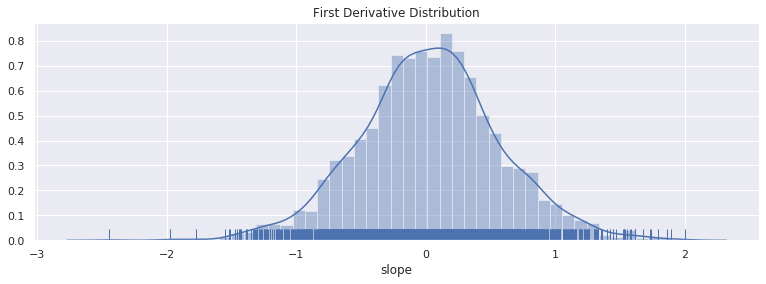

In [21]:
df = fd
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((df), hist=True, rug=True).set_title('First Derivative Distribution')
plt.show()